In [31]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

# SVGD

In [32]:
from svgd import SVGD, get_bandwidth

# Experiment 1: one-dim Gaussian mixture

## Experiment 1.1
Target distribution:
$$ p(x) = \mathcal N(x; 0, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(x; -10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

In [33]:
from jax.scipy.stats import norm

@jit
def logp11(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

In [34]:
n = 100
stepsize = 0.01
L = 300
svgd_adaptive11 = SVGD(logp11, n_iter=L, adaptive_kernel=True, get_bandwidth=get_bandwidth)

In [35]:
# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,1)) - 10

In [6]:
xout11, log11 = svgd_adaptive11.svgd(x0, stepsize, bandwidth=0)

### Diagnostics

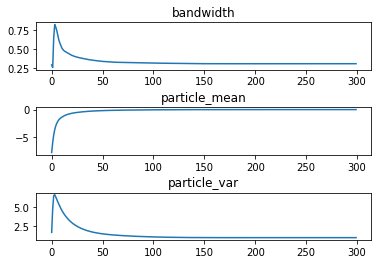

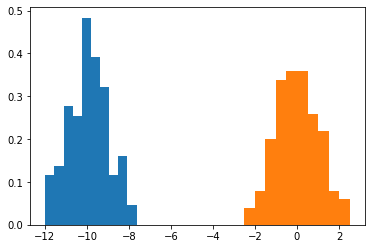

In [14]:
plt.figure(1)
plt.subplots_adjust(hspace=0.8)

l = len(log11)
for i, key in enumerate(log11.keys()):
    plt.subplot(f"{l}1{i+1}") # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
    plt.title(key)
    plt.plot(log11[key])

plt.figure(2)
_ = plt.hist(x0[:, 0], density=True)
_ = plt.hist(xout11[:, 0], density=True)

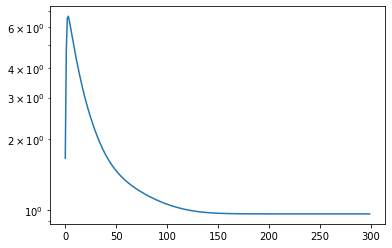

In [15]:
plt.plot(log11["particle_var"])
plt.yscale('log')

Now compute some MSE values and metrics.

In [37]:
np.mean(xout11) - 0

DeviceArray(8.222431e-05, dtype=float32)

In [38]:
np.mean(xout11**2) - 1

DeviceArray(-0.03692579, dtype=float32)

In [40]:
np.var(xout11) - 1

DeviceArray(-0.03692597, dtype=float32)

## Experiment 1.2
Target distribution:
$$ p(x) = 1/3 \mathcal N(-2, 1) + 2/3 \mathcal N(2, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(-10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

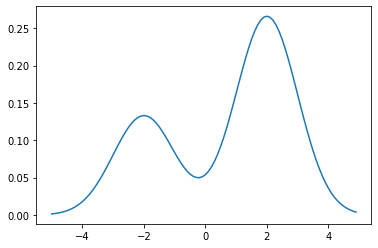

In [16]:
from jax.scipy.stats import norm

def p12(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    out = 1/3 * norm.pdf(x, loc=-2, scale=1) + 2/3 * norm.pdf(x, loc=2, scale=1)
    return np.squeeze(out) # to be able to take a gradient, output must be scalar

grid = np.arange(-5, 5, 0.1)
_ = plt.plot(grid, p12(grid))

def logp12(x):
    return np.log(p12(x))

In [17]:
# experiment:
n = 100
d = 1
stepsize = 0.001
L = 2000
svgd_adaptive12 = SVGD(logp12, n_iter=L, adaptive_kernel=True, get_bandwidth=get_bandwidth)

In [18]:
# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10

In [19]:
xout12, log12 = svgd_adaptive12.svgd(x0, stepsize, bandwidth=0)

## Diagnostics

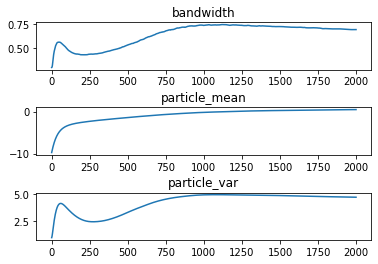

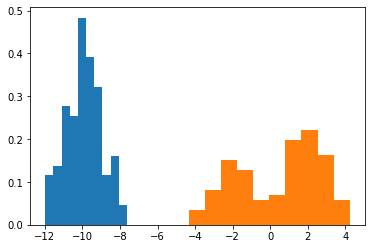

In [20]:
plt.figure(1)
plt.subplots_adjust(hspace=0.8)

l = len(log12)
for i, key in enumerate(log12.keys()):
    plt.subplot(f"{l}1{i+1}") # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
    plt.title(key)
    plt.plot(log12[key])

plt.figure(2)
_ = plt.hist(x0[:, 0], density=True)
_ = plt.hist(xout12[:, 0], density=True)

Now compute some MSE values and metrics.

In [42]:
## test functions
se1 = (np.mean(xout12) - 2/3)**2
se2 = (np.mean(xout12**2) - 5)**2
print(se1)
print(se2)

0.036466036
0.0012394512


In [43]:
np.var(xout12) - (5 - 4/9)

DeviceArray(0.18294382, dtype=float32)

In [44]:
np.mean(xout12**2, axis=0)

DeviceArray([4.964795], dtype=float32)

# Experiment 2: Multi-dim Gaussian

### Experiment 2.1
Same as before, only now $X$ is $d$-dimensional.
#### Target distribution:
$$ p(x) = \mathcal N(x; \mu, \Sigma), \ \ \ \text { where we take } \mu = (1, \dots, 1)^T \text{ and } \Sigma = I. $$
#### Initialization:
$$ q_0(x) = \mathcal N(x; \mu_0, \Sigma_0), \ \ \ \text{ with } \mu = (-10, \dots, -10) \text{ and } \Sigma = I. $$

#### Kernel:
We'll use a natural generalization of the RBF kernel: $k(x, y) = \exp(-\frac{1}{2} (x - y)^T \sigma^{-1} (x - y))$. The easiest way to adaptively choose the kernel is to let $\Sigma = \text{diag}(h_1, \dots, h_d)$ be diagonal, in which case the kernel is given by $k(x, y) = \exp(-\frac{1}{2} \sum_{k=1}^d \frac{(x_k - y_k)^2}{h_k})$. Then choose the bandwidth parameter
$$ h_k = \text{med}_k^2 / \log n, $$
where med$_k$ is the $k$-th entry in the ($d$-dimensional) median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$.

In [23]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1))

In [24]:
n = 100
d = 2
stepsize = 0.001
L = int(3 / stepsize)

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10

svgd_adaptive21 = SVGD(logp=logp, n_iter=L, adaptive_kernel=True, get_bandwidth=get_bandwidth)

In [25]:
xout21, log21 = svgd_adaptive21.svgd(x0, stepsize, bandwidth=0)

### Diagnostics

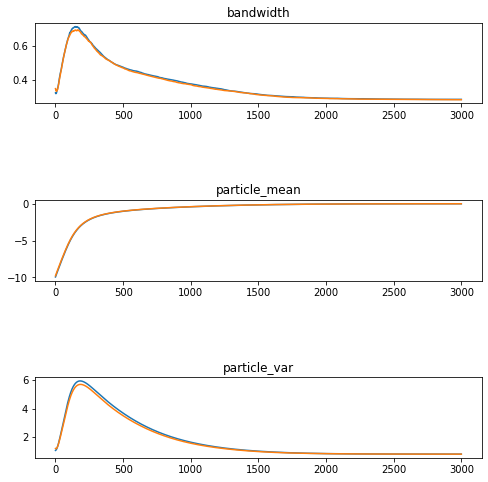

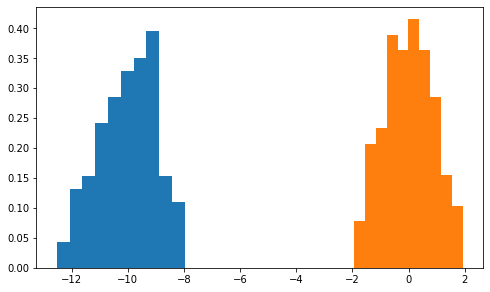

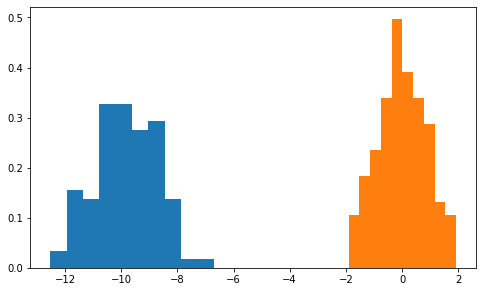

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 8]

plt.figure(1)
plt.subplots_adjust(hspace=1.2)
log21["particle_mean"] = np.array(log21["particle_mean"])
log21["particle_var"] = np.array(log21["particle_var"])
log21["bandwidth"] = np.array(log21["bandwidth"])

l = len(log21)
for i, key in enumerate(log21.keys()):
    plt.subplot(f"{l}1{i+1}") # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
    plt.title(key)
    plt.plot(log21[key])

mpl.rcParams['figure.figsize'] = [8.0, 4.8]

for dim in range(d):
    plt.figure(dim+2)
    _ = plt.hist(x0[:, dim], density=True)
    _ = plt.hist(xout21[:, dim], density=True)

In [27]:
np.mean(xout21, axis=0)

DeviceArray([-0.00214993, -0.00091851], dtype=float32)

In [28]:
np.var(xout21, axis=0)

DeviceArray([0.78173196, 0.78046006], dtype=float32)

In [29]:
np.var(x0, axis = 0)

DeviceArray([1.0403997, 1.1901261], dtype=float32)

# Experiment 3: Bayesian logistic regression

In [ ]:
# number of samples
n = 500

First, $\alpha \sim \text{Gamma}(a, b)$.

In [ ]:
from jax.scipy.stats import gamma

# Generate regression parameters
a = 2 # shape
# b = 1 # rate parameter (1 / scale)

key = random.PRNGKey(0)
gamma_samples = random.gamma(key, a, shape=(1000,))

count, bins, ignored = plt.hist(gamma_samples, bins = 100, density=True)
y = gamma.pdf(bins, a)
_ = plt.plot(bins, y, 'r')

In [ ]:
_ = plt.plot(bins, 1 / y)

In [ ]:
key = random.PRNGKey(0)
alpha = random.gamma(key, a, shape=(1,))

In [ ]:
print(alpha)

Now, $p(\beta \ \vert \alpha) = \mathcal N (\beta;\ 0, \alpha^{-1})$.

In [ ]:
beta = random.normal(key, shape=(2,)) * 1 / np.sqrt(alpha)

Finally, $\log \frac{\pi_i}{1 - \pi_i} = \beta_0 + \beta_1 X_i$. In other words,
$$ \pi_i = \frac{\text{exp}(\beta_0 + \beta_1 X_i)}{1 - \text{exp}(\beta_0 + \beta_1 X_i)}.$$

In [ ]:
x = np.linspace(start=-10, stop=10, num=n)
pi = np.exp(beta[0] + beta[1] * x / (1 - np.exp(beta[0] + beta[1] * x)))

We can now sample the $Y_i$, which are distributed as
$$Y_i \ \vert X_i \sim \text{Bernoulli}(\pi_i).$$

In [ ]:
y = random.bernoulli(key, p=pi, shape=(n,))

### Bayesian inference
We now have a set of observations $\{(y_i, x_i)\}_{i=1, \dots, n}$, (that is, `x` and `y`) and a prior $p(\beta_0, \beta_1)$ over the logistic regression parameters.

The prior is given as follows. Choose $\beta_0, \beta_1$ to be independently identically distributed as 
$$p(\beta) = p(\beta \vert \alpha) \ p(\alpha),$$
where 
\begin{align}   
    p(\beta \vert \alpha) &= \mathcal N(\beta; 0, \alpha^{-1}) \\
    p(\alpha) &= \text{Gamma}(\alpha; a, b),
\end{align}
and $a, b$ are fixed parameters.



Then the posterior is given by
\begin{equation}
    p(\beta_0, \beta_1 \vert x, y) \propto p(y \vert x; \beta_0, \beta_1) p(\beta_0, \beta_1).
\end{equation}

This posterior is the target distribution for SVGD.

In [ ]:
from jax.scipy.stats import norm, gamma

In [ ]:
def p(beta, alpha, x, y, a, b):
    """
    IN:
    * beta: np array w/ shape (2,), regression parameters
    * alpha: scalar > 0, precision parameter for beta prior
    * x: np array of shape (n,)
    * y: np array of shape (n,) and type bool (bernoulli sample)
    * a, b: scalars > 0, parameters for gamma prior on alpha
    
    OUT:
    * scalar, unnormalized posterior pdf evaluated at beta and alpha: p(beta, alpha | x, y, a, b)
    """
    assert beta.shape[0] == 2
    pi = np.exp(beta[0] + beta[1] * x) / (1 - np.exp(beta[0] + beta[1] * x))
    
    p1 = pi * y + (1 - pi) * (1 - y)
    p1 = np.prod(p1) # likelihood of all x's
    p2 = np.prod(norm.pdf(beta, loc=0, scale=1/alpha))
    p3 = gamma.pdf(alpha, a)
    
    return p1 * p2 * p3

In [ ]:
pb = vmap(p, in_axes=(0, None, None, None, None, None))
pbb = vmap(pb, in_axes=(0, None, None, None, None, None))

In [ ]:
def logp(beta, alpha, x, y, a, b):
    """
    IN:
    * beta: np array w/ shape (2,), regression parameters
    * alpha: scalar > 0, precision parameter for beta prior
    * x: np array of shape (n,)
    * y: np array of shape (n,) and type bool (bernoulli sample)
    * a, b: scalars > 0, parameters for gamma prior on alpha
    
    OUT:
    * scalar, unnormalized posterior pdf evaluated at beta and alpha: p(beta, alpha | x, y, a, b)
    """
    assert beta.shape[0] == 2
    
    log_pi = beta[0] + beta[1] * x - np.log(1 + np.exp(beta[0] + beta[1] * x)) # array of length n
    one_minus_log_pi = np.log(1 + np.exp(beta[0] + beta[1] * x)) # array of length n
    
    log_p1 = y * log_pi + (1 - y) * one_minus_log_pi # array of length n
    log_p1 = np.sum(log_p1) # scalar
    
    log_p2 = np.sum(norm.logpdf(beta, loc=0, scale=1/alpha))
    log_p3 = gamma.logpdf(alpha, a)
    
    return log_p1 + log_p2 + log_p3

In [ ]:
logpb = vmap(logp, in_axes=(0, None, None, None, None, None))
logpbb = vmap(logpb, in_axes=(0, None, None, None, None, None))

### quick 3d plot of beta

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [ ]:
# make data
num = 60
X = np.linspace(-7, 7, num)
Y = np.linspace(-7, 7, num)
X, Y = np.meshgrid(X, Y) # both shape (40, 40)
bet = np.array(list(zip(X, Y))).reshape(num, num, 2)

b = np.array(1)
print(logpbb(bet, alpha, x, y, a, b).shape)

Z = logpbb(bet, alpha, x, y, a, b)
Z = np.squeeze(Z)

In [ ]:
1 / alpha

In [ ]:
# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.xlabel("beta_0")
plt.ylabel("beta_1")
ax.set_zlabel("p(beta_0, beta_1, alpha)")

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)